In [1]:
%matplotlib inline
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime,timedelta

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


In [2]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [3]:
#Fetch only Finance Data
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("tesla")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbSentimentData = SqlConn.fetchTweetSentimentForModelling("tesla")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [5]:
df_dbFinanceData["date"] = pd.to_datetime(df_dbFinanceData["date"])
df_dbFinanceData.set_index("date", inplace=True)
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id
date,,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028


In [6]:
df_dbSentimentData["date"] = pd.to_datetime(df_dbSentimentData["date"])
df_dbSentimentData.set_index("date",inplace=True)
df_dbSentimentData

,tweetID,financeType,fullText,replyCount,likesCount,retweetCount,sentimentScore,sentiment,id,adjustedClose,volume
date,,,,,,,,,,,
2012-01-11,156927468836630528,tesla,The exec conf room at Tesla used to be called ...,32.0,315,67,0.6616,None,389,5.646000,3361500
2012-01-13,157700726515183616,tesla,"A Tesla Roadster just passed the 100,000 mile ...",5.0,15,51,0.0000,None,391,4.558000,27502000
2012-01-17,159330976378519552,tesla,Will communicate better in the future. Too man...,44.0,163,43,-0.0772,None,392,5.320000,23258000
2012-01-17,159396536621596672,tesla,That's not just paranoia (a healthy trait at t...,23.0,16,14,0.0875,None,392,5.320000,23258000
2012-02-10,168022238061268993,tesla,Tesla Model X video,12.0,16,47,0.0000,None,410,6.220000,9371000
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15,1537080831751102467,tesla,Buyers of competing electric cars receive a $7...,NaN,40507,3823,0.2023,None,3013,699.000000,39710600
2022-07-06,1544513390357381120,tesla,Zip around Vegas super fast with Teslas in tun...,NaN,13671,752,0.6360,None,3026,695.200012,23951200
2022-07-07,1545051509020192768,tesla,Maybe Tesla should make a highly configurable ...,NaN,120221,6731,0.0000,None,3027,733.630005,27310200


In [7]:
df_dbFinanceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3030 entries, 2010-06-29 to 2022-07-12
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   financeType    3030 non-null   object 
 1   open           3030 non-null   float64
 2   high           3030 non-null   float64
 3   low            3030 non-null   float64
 4   close          3030 non-null   float64
 5   adjustedClose  3030 non-null   float64
 6   volume         3030 non-null   int64  
 7   id             3030 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 213.0+ KB


<AxesSubplot:xlabel='date'>

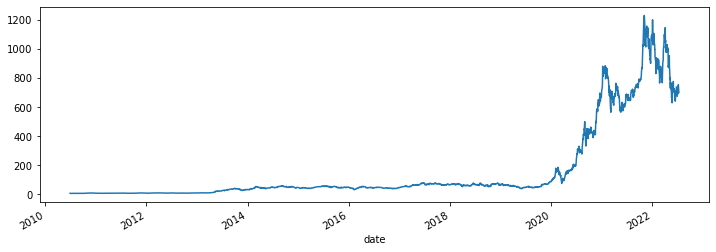

In [8]:
df_dbFinanceData['adjustedClose'].plot(figsize=(12,4))

In [9]:
df_dbFinanceData.index

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=3030, freq=None)

<AxesSubplot:xlabel='date'>

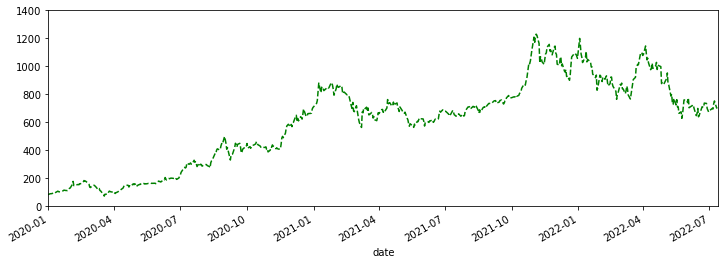

In [10]:
df_dbFinanceData['adjustedClose'].plot(xlim=['2020-01-01','2022-07-13'],ylim=[0,1400],figsize=(12,4),ls='--',c='green')

<AxesSubplot:xlabel='date'>

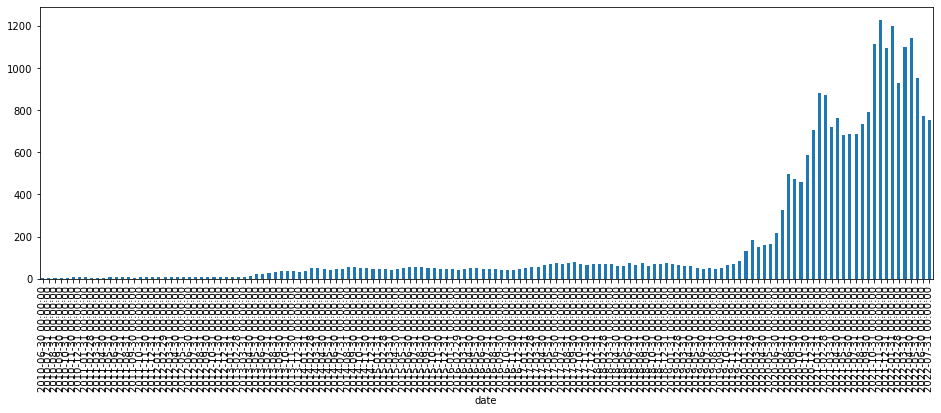

In [11]:
#Resampling to display monthly data
df_resampled = df_dbFinanceData['adjustedClose'].resample(rule='M')
df_resampled.max().plot(kind='bar',figsize=(16,5))

In [12]:
df_filteredData = df_dbFinanceData.loc['2020-01-01':'2022-7-13']
df_filteredData.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=636, freq=None)

<AxesSubplot:xlabel='date'>

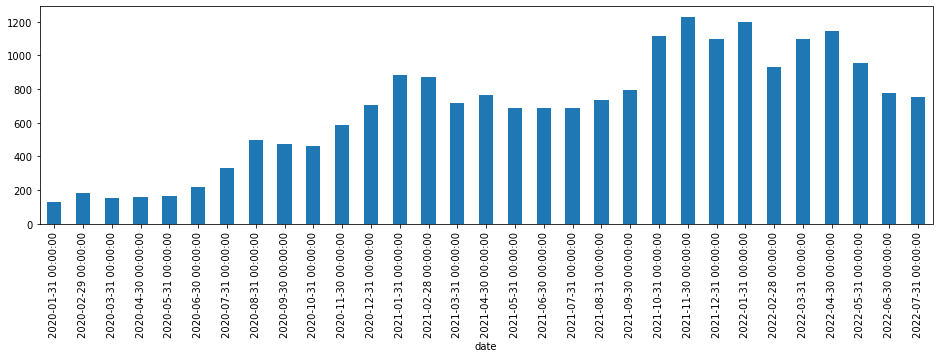

In [13]:
#Nov 2021 was the month when Tesla had highest value - checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData['adjustedClose'].resample(rule='M').max().plot(kind='bar', figsize=(16,4))

<AxesSubplot:xlabel='date'>

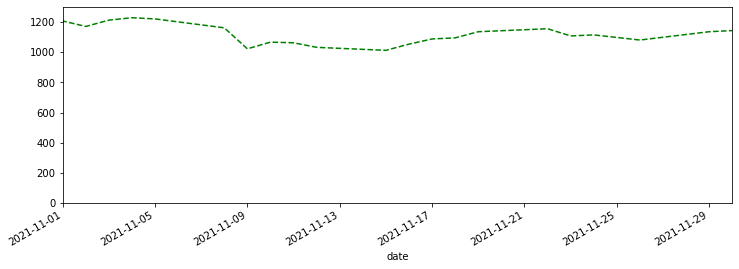

In [14]:
df_filteredData['adjustedClose'].plot(xlim=['2021-11-01','2021-11-30'],ylim=[0,1300],figsize=(12,4),ls='--',c='green')


<AxesSubplot:xlabel='date'>

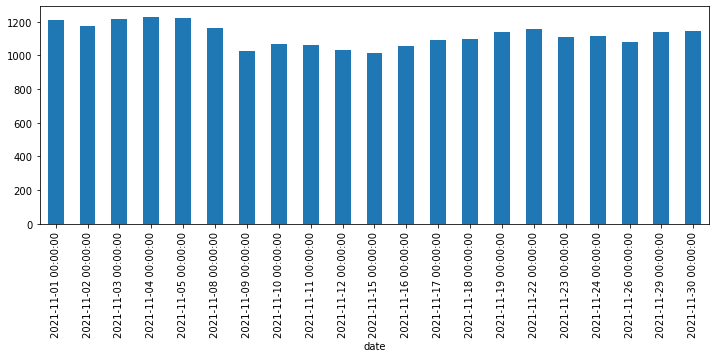

In [15]:
# checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData.loc['2021-11-01':'2021-11-30']['adjustedClose'].plot(kind='bar',figsize=(12,4))

In [16]:
#5 and 15 days rolling mean
df_dbFinanceData["adjustedClose:5 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(5).mean() 
df_dbFinanceData["adjustedClose:15 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(15).mean() 
df_dbFinanceData["adjustedClose:60 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(60).mean() 
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1,NaN,NaN,NaN
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2,NaN,NaN,NaN
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3,NaN,NaN,NaN
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4,NaN,NaN,NaN
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5,4.199600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026,687.015991,692.051998,790.372000
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027,696.647998,696.782666,785.507667
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028,712.421997,700.335331,781.780333


<AxesSubplot:xlabel='date'>

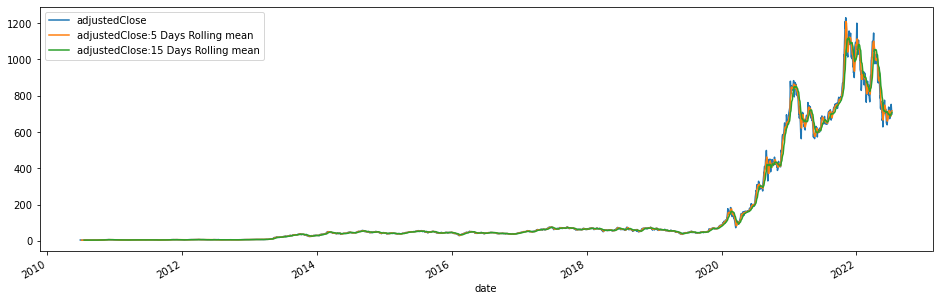

In [17]:
#smoothening the line
df_dbFinanceData[['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean']].plot(figsize=(16,5))

<AxesSubplot:xlabel='date'>

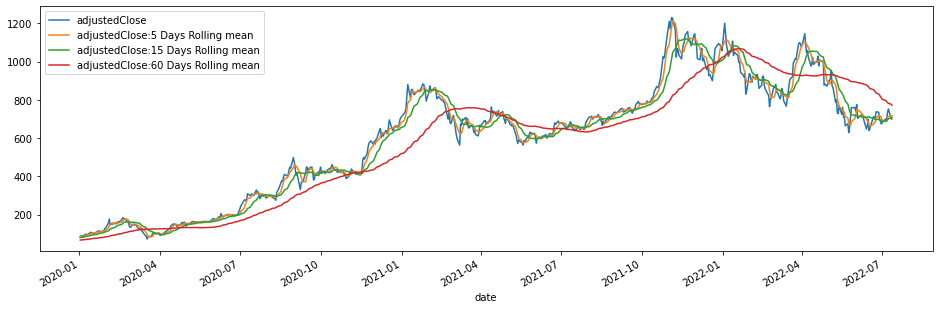

In [18]:
#smoothening the line
df_dbFinanceData.loc['2020-01-01':'2022-7-13'][['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean','adjustedClose:60 Days Rolling mean']].plot(figsize=(16,5))

#rolling mean of 5 days is closer compared to 15 days

<AxesSubplot:xlabel='date'>

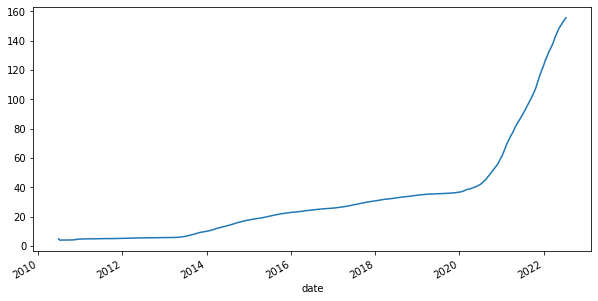

In [19]:
#Cummulative moving average
df_dbFinanceData['adjustedClose'].expanding().mean().plot(figsize=(10,5))

In [20]:
#exponential weighted moving average
df_dbFinanceData['emw0.2']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.2,adjust=False).mean()
df_dbFinanceData['emw0.4']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.4,adjust=False).mean()
df_dbFinanceData['emw_span5']=df_dbFinanceData['adjustedClose'].ewm(span=2,).mean()

<AxesSubplot:xlabel='date'>

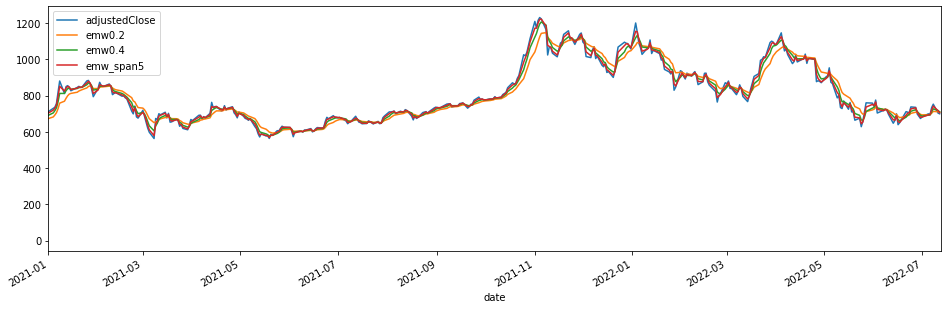

In [21]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-01-01','2022-7-13'],figsize=(16,5))

<AxesSubplot:xlabel='date'>

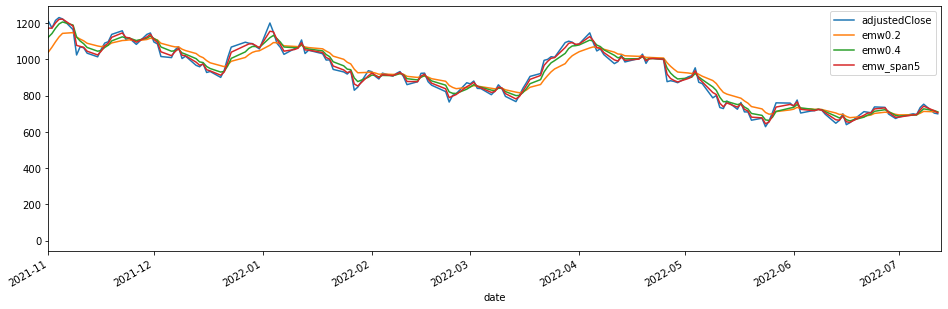

In [22]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-11-01','2022-7-13'],figsize=(16,5))

# Applying ARIMA Model

In [23]:
#Augmented Dickey–Fuller test
def adf_test(series):
    results = adfuller(series)
    print('ADF statistics: {}'.format(results[0]))
    print('P value: {}'.format(results[1]))
    if results[1] < 0.05:
        print("Ho Rejected - data is stationary")
    else:    
        print("Ho Accepted- data is not stationary")

In [24]:
adf_test(df_dbFinanceData['adjustedClose'])

ADF statistics: -0.3586377728879778
P value: 0.9167791107833695
Ho Accepted- data is not stationary


In [25]:
df_dbFinanceData['adjustedClose_first_diff']=df_dbFinanceData['adjustedClose']-df_dbFinanceData['adjustedClose'].shift(1)

In [26]:
adf_test(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#d=1

ADF statistics: -10.966950784001796
P value: 8.058634793412424e-20
Ho Rejected - data is stationary


In [27]:
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1,NaN,NaN,NaN,4.778000,4.778000,4.778000,NaN
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2,NaN,NaN,NaN,4.775600,4.773200,4.769000,-0.012000
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3,NaN,NaN,NaN,4.698880,4.620720,4.508000,-0.374000
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4,NaN,NaN,NaN,4.527104,4.308432,4.057100,-0.552000
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5,4.199600,NaN,NaN,4.266083,3.873859,3.498066,-0.618000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026,687.015991,692.051998,790.372000,694.657106,693.169146,694.535709,-4.000000
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027,696.647998,696.782666,785.507667,702.451686,709.353490,720.598573,38.429993
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028,712.421997,700.335331,781.780333,712.419344,726.528085,741.726176,18.659973


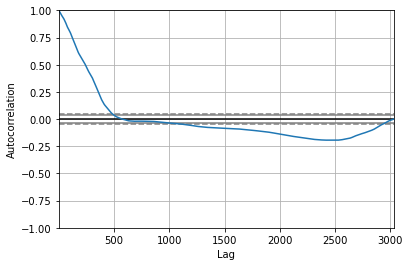

In [74]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_dbFinanceData['adjustedClose'])
plt.show()

# Calculate AR(p), I(d), MA(q) 

In [28]:
#Estimate ARIMA differencing term,
ndiffs(df_dbFinanceData['adjustedClose'],test='adf')

1

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


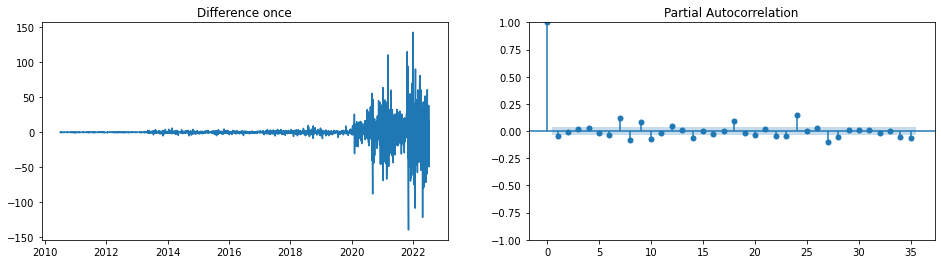

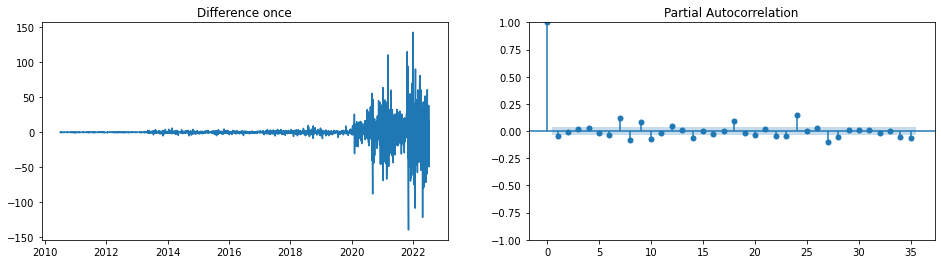

In [29]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)
#p=2

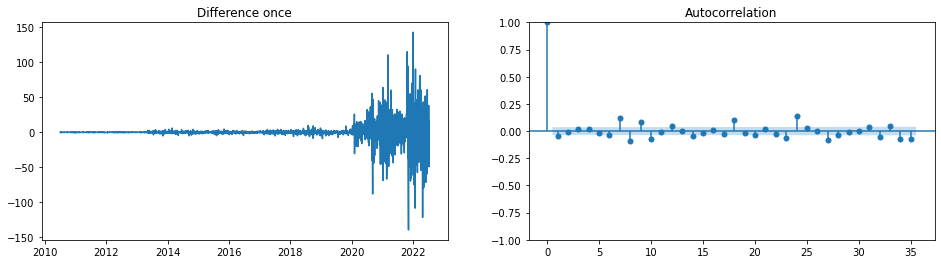

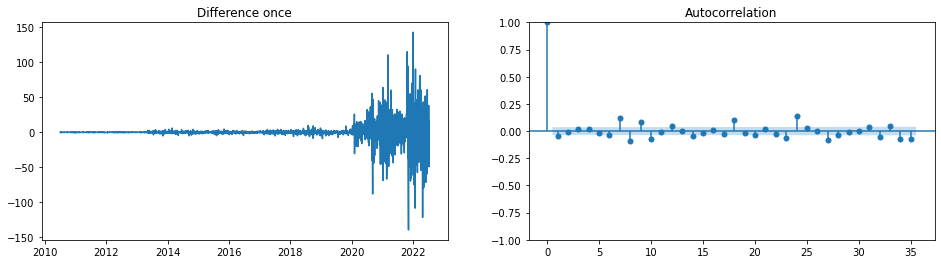

In [30]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
#q=2

#Other ways to find P and Q

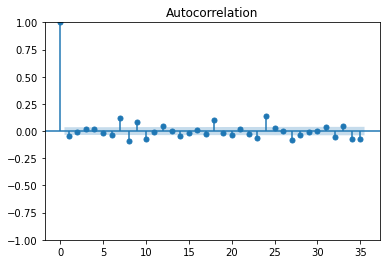

In [31]:
acf = plot_acf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#q=2

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


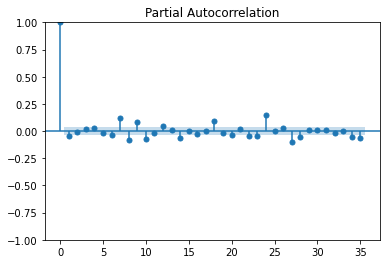

In [32]:
acf = plot_pacf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#p=2

third way to find p,d,q- using Auto_arima

In [33]:
stepwise_fit = auto_arima(df_dbFinanceData['adjustedClose'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23916.803, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23913.452, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23913.378, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23915.816, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23915.337, Time=1.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23915.303, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23902.278, Time=3.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23918.050, Time=3.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23916.311, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23901.383, Time=3.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23915.240, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23917.977, Time=2.77 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23916.522, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3030
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -11913.057
Date:                Thu, 28 Jul 2022   AIC                          23840.114
Time:                        19:33:04   BIC                          23882.226
Sample:                             0   HQIC                         23855.255
                               - 3030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1588      0.011   -107.115      0.000      -1.180      -1.138
ar.L2         -0.9539      0.014    -69.001      0.000      -0.981      -0.927
ar.L3         -0.0503      0.011     -4.740      0.000      -0.071      -0.029
ar.L4          0.0459      0.007      6.487      0.000       0.032       0.060
ma.L1          1.1329      0.007    151.321      0.000       1.118       1.148
ma.L2          0.9229      0.008    118.057      0.000       0.908       0.938
sigma2       152.6233      1.030    148.153      0.000     150.604     154.642
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            111100.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             892.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting the Model and Predicting

In [34]:
df_arima = df_dbFinanceData.copy()
df_arima.drop(columns=['financeType'],inplace=True)
train_dataset_end=datetime(2021,7,31)
test_dataset_end=datetime(2022,7,31)

In [35]:
train_data=df_arima[:train_dataset_end]
test_data=df_arima[train_dataset_end+timedelta(days=1):test_dataset_end]

In [36]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [37]:
train_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1,NaN,NaN,NaN,4.778000,4.778000,4.778000,NaN
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2,NaN,NaN,NaN,4.775600,4.773200,4.769000,-0.012000
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3,NaN,NaN,NaN,4.698880,4.620720,4.508000,-0.374000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4,NaN,NaN,NaN,4.527104,4.308432,4.057100,-0.552000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5,4.199600,NaN,NaN,4.266083,3.873859,3.498066,-0.618000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,650.969971,668.200012,647.109985,657.619995,657.619995,25336600,2788,653.209998,655.246663,633.704168,653.433650,652.344990,653.757041,14.239990
2021-07-27,663.400024,666.500000,627.239990,644.780029,644.780029,32813300,2789,650.066003,654.259998,632.626501,651.702925,649.319006,647.772366,-12.839966
2021-07-28,647.000000,654.969971,639.400024,646.979980,646.979980,16006600,2790,648.404004,654.415328,631.994501,650.758336,648.383395,647.244109,2.199951


In [38]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,2793,673.195996,659.665991,633.096834,671.775064,686.385206,699.970512,22.469971
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,2794,686.187988,662.412659,633.719668,679.368049,695.727120,706.483497,0.070007
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,2795,698.975989,666.248657,635.084334,685.678436,701.804265,709.441154,1.179993
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,2796,706.431995,670.517326,636.708168,691.468750,706.934561,712.900388,3.710022
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,2797,708.811987,674.175993,638.528334,692.994995,703.800727,703.700113,-15.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026,687.015991,692.051998,790.372000,694.657106,693.169146,694.535709,-4.000000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027,696.647998,696.782666,785.507667,702.451686,709.353490,720.598573,38.429993
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028,712.421997,700.335331,781.780333,712.419344,726.528085,741.726176,18.659973


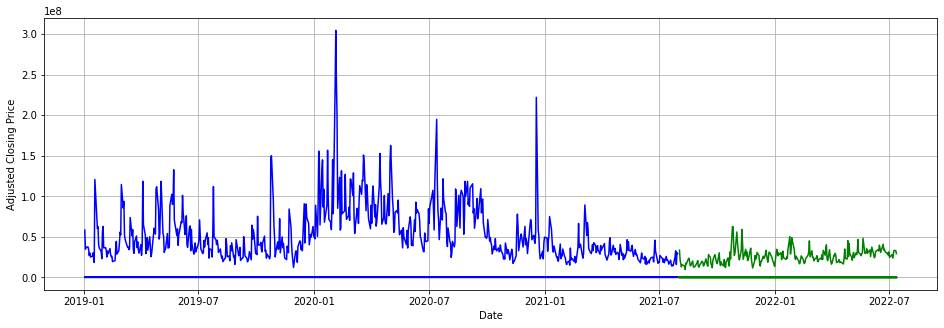

In [39]:
startdate=datetime(2019,1,1)
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.plot(train_data[startdate:],'blue', label="training data")
plt.plot(test_data, 'green' , label="testing data")
#plt.legend(loc="upper left")

# Train the ARIMA Model

In [40]:
train_data[['adjustedClose','open','high','low']]

,adjustedClose,open,high,low
date,,,,
2010-06-29,4.778000,3.800000,5.000000,3.508000
2010-06-30,4.766000,5.158000,6.084000,4.660000
2010-07-01,4.392000,5.000000,5.184000,4.054000
2010-07-02,3.840000,4.600000,4.620000,3.742000
2010-07-06,3.222000,4.000000,4.000000,3.166000
...,...,...,...,...
2021-07-26,657.619995,650.969971,668.200012,647.109985
2021-07-27,644.780029,663.400024,666.500000,627.239990
2021-07-28,646.979980,647.000000,654.969971,639.400024


In [41]:
model_ARIMA=sm.tsa.arima.ARIMA(df_arima['adjustedClose'],order=(4,1,2))

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [42]:
model_ARIMA_fit = model_ARIMA.fit()

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [43]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adjustedClose   No. Observations:                 3030
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -11913.057
Date:                Thu, 28 Jul 2022   AIC                          23840.114
Time:                        19:33:09   BIC                          23882.226
Sample:                             0   HQIC                         23855.255
                               - 3030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1588      0.011   -107.115      0.000      -1.180      -1.138
ar.L2         -0.9539      0.014    -69.001      0.000      -0.981      -0.927
ar.L3         -0.0503      0.011     -4.740      0.000      -0.071      -0.029
ar.L4          0.0459      0.007      6.487      0.000       0.032       0.060
ma.L1          1.1329      0.007    151.321      0.000       1.118       1.148
ma.L2          0.9229      0.008    118.057      0.000       0.908       0.938
sigma2       152.6233      1.030    148.153      0.000     150.604     154.642
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            111100.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             892.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

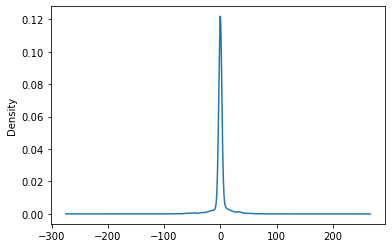

In [44]:
model_ARIMA_fit.resid.plot(kind='kde')

(array([2.43856254e-05, 2.43856254e-05, 1.46313752e-04, 5.36483758e-04,
        2.17032066e-03, 3.29327871e-02, 8.65689701e-04, 1.58506565e-04,
        4.87712507e-05, 3.65784381e-05]),
 array([-139.43931345, -112.37148162,  -85.30364979,  -58.23581796,
         -31.16798613,   -4.1001543 ,   22.96767753,   50.03550936,
          77.10334119,  104.17117303,  131.23900486]),
 <BarContainer object of 10 artists>)

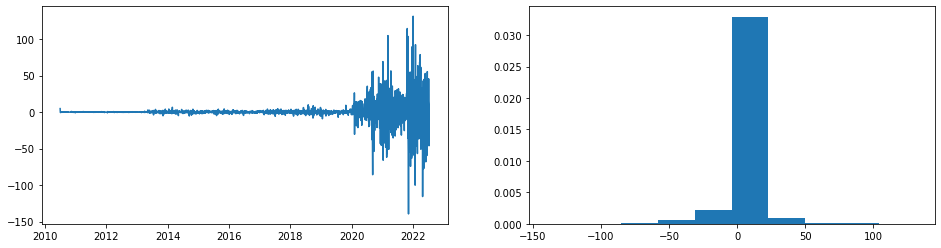

In [45]:
resids = pd.DataFrame(model_ARIMA_fit.resid)
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,4))
ax1.plot(resids)
ax2.hist(resids, density=True)

In [46]:
##prediction
pred_start_date=pd.to_datetime(test_data.index[0])
pred_end_date=pd.to_datetime(test_data.index[-1])
print(pred_start_date)
print(pred_end_date)

2021-08-02 00:00:00
2022-07-12 00:00:00


In [47]:
-len(train_data)

-2792

Predicted Adjustclose Values
date
2021-08-02    686.575399
2021-08-03    711.242480
2021-08-04    708.734803
2021-08-05    709.897546
2021-08-06    717.611013
                 ...    
2022-07-06    697.825766
2022-07-07    688.070424
2022-07-08    741.613962
2022-07-11    749.149906
2022-07-12    697.799984
Name: predicted_mean, Length: 238, dtype: float64


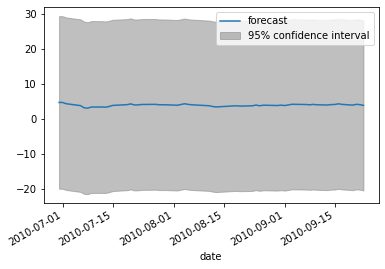

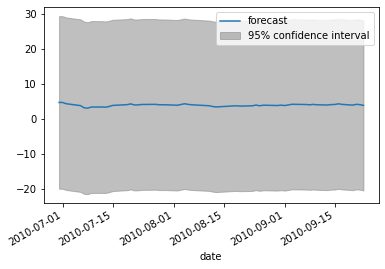

In [48]:
from statsmodels.graphics.tsaplots import plot_predict
adjustedCloseByArima_pred =model_ARIMA_fit.predict(start=len(train_data),end=(len(train_data) + len(test_data)-1)) 
adjustedCloseByArima_predictions = model_ARIMA_fit.get_prediction(start = -len(test_data))
residuals = test_data['adjustedClose']-adjustedCloseByArima_pred
print("Predicted Adjustclose Values")
print(adjustedCloseByArima_pred)
plot_predict(model_ARIMA_fit, start=1, end=60,dynamic=False)

In [49]:
df_yPred = adjustedCloseByArima_predictions.summary_frame(alpha=0.10)

# Extract prediction mean
mean_forecast = adjustedCloseByArima_predictions.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = adjustedCloseByArima_predictions.conf_int()
confidence_intervals


,lower adjustedClose,upper adjustedClose
date,,
2021-08-02,662.361845,710.788952
2021-08-03,687.028927,735.456033
2021-08-04,684.521250,732.948356
2021-08-05,685.683993,734.111099
2021-08-06,693.397459,741.824566
...,...,...
2022-07-06,673.612212,722.039319
2022-07-07,663.856871,712.283977
2022-07-08,717.400408,765.827515


<AxesSubplot:xlabel='date'>

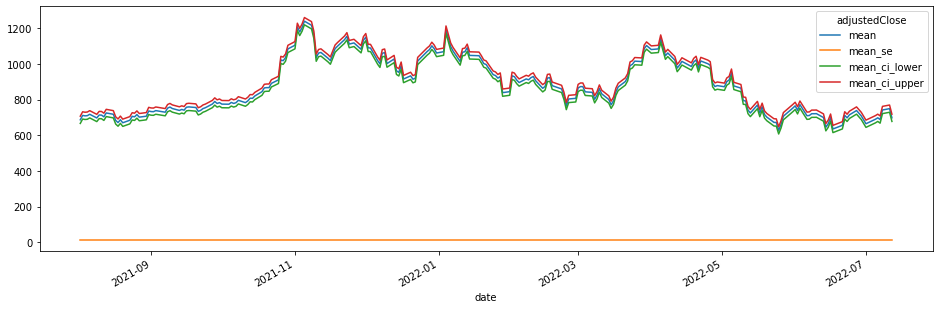

In [50]:
df_yPred.plot(figsize=(16,5))

In [51]:
d1 = pd.DataFrame(test_data['adjustedClose'])
d2 = pd.DataFrame(mean_forecast)
d2['date'] = d1.index
d2.set_index('date',inplace=True)
df_y_yPred = pd.concat([d1,d2],axis=1)

In [52]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-02,709.669983,686.575399
2021-08-03,709.739990,711.242480
2021-08-04,710.919983,708.734803
2021-08-05,714.630005,709.897546
2021-08-06,699.099976,717.611013
...,...,...
2022-07-06,695.200012,697.825766
2022-07-07,733.630005,688.070424
2022-07-08,752.289978,741.613962


<AxesSubplot:xlabel='date'>

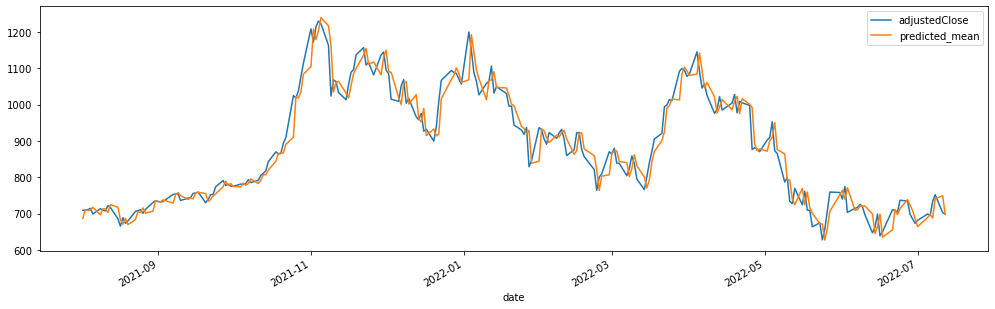

In [53]:
df_y_yPred.plot(figsize=(17,5))

# Forecasting

In [54]:
forecast_pred =model_ARIMA_fit.predict(start=len(df_arima),end=len(df_arima) + 30) 

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [55]:
forecast_pred

3030    710.485725
3031    705.697178
3032    698.421319
3033    710.678112
3034    704.174122
3035    700.164683
3036    710.064977
3037    703.306955
3038    701.596881
3039    709.343428
3040    702.792309
3041    702.769750
3042    708.577275
3043    702.554033
3044    703.694133
3045    707.825765
3046    702.519886
3047    704.393182
3048    707.128500
3049    702.628243
3050    704.896051
3051    706.509558
3052    702.828309
3053    705.234339
3054    705.980903
3055    703.079736
3056    705.439466
3057    705.545465
3058    703.351732
3059    705.540887
3060    705.199781
Name: predicted_mean, dtype: float64

In [56]:
step = 30
fc = model_ARIMA_fit.forecast(step)
lst_fc = list(fc)
lst_fc

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[710.4857245101272,
 705.6971777130735,
 698.4213191842161,
 710.6781118647633,
 704.1741215594515,
 700.164682908587,
 710.0649766989295,
 703.3069553407055,
 701.596881150745,
 709.3434278208032,
 702.792308769685,
 702.7697501554122,
 708.577274700385,
 702.5540326132909,
 703.6941326311744,
 707.8257647710541,
 702.519885962761,
 704.3931818596219,
 707.1285003856627,
 702.6282427806834,
 704.8960513979168,
 706.5095576606963,
 702.8283094031196,
 705.2343389454923,
 705.9809030991095,
 703.0797358302118,
 705.439466313282,
 705.5454654538961,
 703.3517317912246,
 705.5408872420223]

In [57]:
fc

3030    710.485725
3031    705.697178
3032    698.421319
3033    710.678112
3034    704.174122
3035    700.164683
3036    710.064977
3037    703.306955
3038    701.596881
3039    709.343428
3040    702.792309
3041    702.769750
3042    708.577275
3043    702.554033
3044    703.694133
3045    707.825765
3046    702.519886
3047    704.393182
3048    707.128500
3049    702.628243
3050    704.896051
3051    706.509558
3052    702.828309
3053    705.234339
3054    705.980903
3055    703.079736
3056    705.439466
3057    705.545465
3058    703.351732
3059    705.540887
Name: predicted_mean, dtype: float64

In [58]:
import datetime
end_date = pred_end_date 

date_future = end_date + datetime.timedelta(41)

df_future_dates = pd.date_range(start=end_date, end=date_future,freq='B')
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [59]:
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [60]:
df_combine = pd.DataFrame(df_future_dates,lst_fc)
df_combine.columns=['date']
df_combine

,date
710.485725,2022-07-12
705.697178,2022-07-13
698.421319,2022-07-14
710.678112,2022-07-15
704.174122,2022-07-18
700.164683,2022-07-19
710.064977,2022-07-20
703.306955,2022-07-21
701.596881,2022-07-22
709.343428,2022-07-25


In [61]:
df_combine = df_combine.reset_index()
df_combine = df_combine.set_index('date')
df_combine

,index
date,
2022-07-12,710.485725
2022-07-13,705.697178
2022-07-14,698.421319
2022-07-15,710.678112
2022-07-18,704.174122
2022-07-19,700.164683
2022-07-20,710.064977
2022-07-21,703.306955
2022-07-22,701.596881


In [62]:
df_combine.rename(columns={"index":"forecasted_mean"},inplace=True)

In [63]:
df_combine

,forecasted_mean
date,
2022-07-12,710.485725
2022-07-13,705.697178
2022-07-14,698.421319
2022-07-15,710.678112
2022-07-18,704.174122
2022-07-19,700.164683
2022-07-20,710.064977
2022-07-21,703.306955
2022-07-22,701.596881


In [64]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,2793,673.195996,659.665991,633.096834,671.775064,686.385206,699.970512,22.469971
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,2794,686.187988,662.412659,633.719668,679.368049,695.727120,706.483497,0.070007
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,2795,698.975989,666.248657,635.084334,685.678436,701.804265,709.441154,1.179993
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,2796,706.431995,670.517326,636.708168,691.468750,706.934561,712.900388,3.710022
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,2797,708.811987,674.175993,638.528334,692.994995,703.800727,703.700113,-15.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026,687.015991,692.051998,790.372000,694.657106,693.169146,694.535709,-4.000000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027,696.647998,696.782666,785.507667,702.451686,709.353490,720.598573,38.429993
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028,712.421997,700.335331,781.780333,712.419344,726.528085,741.726176,18.659973


In [65]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,2793,673.195996,659.665991,633.096834,671.775064,686.385206,699.970512,22.469971
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,2794,686.187988,662.412659,633.719668,679.368049,695.727120,706.483497,0.070007
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,2795,698.975989,666.248657,635.084334,685.678436,701.804265,709.441154,1.179993
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,2796,706.431995,670.517326,636.708168,691.468750,706.934561,712.900388,3.710022
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,2797,708.811987,674.175993,638.528334,692.994995,703.800727,703.700113,-15.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026,687.015991,692.051998,790.372000,694.657106,693.169146,694.535709,-4.000000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027,696.647998,696.782666,785.507667,702.451686,709.353490,720.598573,38.429993
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028,712.421997,700.335331,781.780333,712.419344,726.528085,741.726176,18.659973


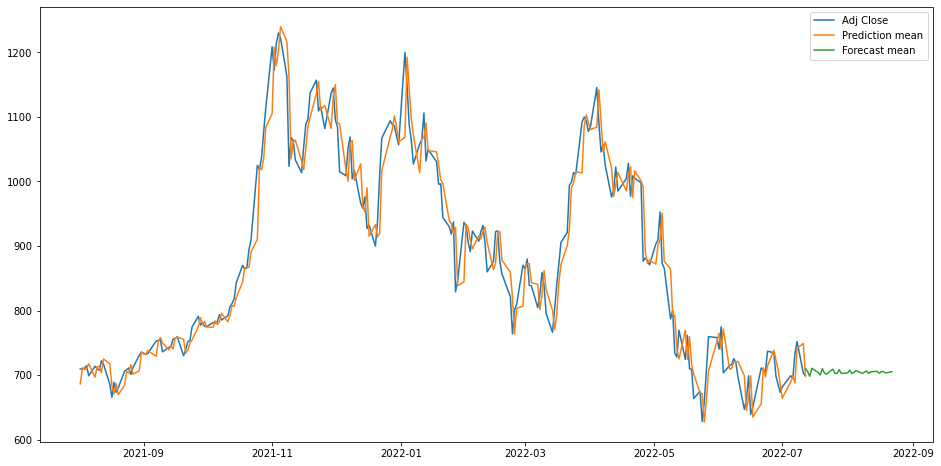

In [66]:
#plot the predictions for validation set
plt.figure(figsize=(16, 8))
plt.plot(test_data["adjustedClose"], label='Adj Close')
#plt.plot(valid, label='Valid')
plt.plot(df_y_yPred["predicted_mean"], label='Prediction mean')
plt.plot(df_combine["forecasted_mean"], label='Forecast mean')
plt.legend()
plt.show()

In [67]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-02,709.669983,686.575399
2021-08-03,709.739990,711.242480
2021-08-04,710.919983,708.734803
2021-08-05,714.630005,709.897546
2021-08-06,699.099976,717.611013
...,...,...
2022-07-06,695.200012,697.825766
2022-07-07,733.630005,688.070424
2022-07-08,752.289978,741.613962


# MAE, RMSE, MAPE

In [68]:
test_data.shape

(238, 14)

In [82]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data["adjustedClose"],adjustedCloseByArima_pred)
mae
#MAE Mean of Absolute value of Errors -

26.087506723190813

In [71]:
from sklearn.metrics import mean_absolute_percentage_error
mape =mean_absolute_percentage_error(test_data["adjustedClose"],adjustedCloseByArima_pred)
mape
#MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) = 19.8% is the difference between Actual vs Predicted

0.029312741478521635

In [72]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_data["adjustedClose"],adjustedCloseByArima_pred))
rmse 
#Root Mean Squared Error = 310 

35.87492552169915

In [73]:
print("TESLA")
print("--------------")
print("MAE :" + str(mae) )
print("MAPE :" + str(mape) )
print("RMSE :" + str(rmse) )


TESLA
--------------
MAE :26.087506723190813
MAPE :0.029312741478521635
RMSE :35.87492552169915


# Scaled Value comparison

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_data_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(test_data["adjustedClose"])),columns=["adjustedClose"])

test_data_scaled.index = test_data.index



In [76]:
df_y_yPred_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_y_yPred["predicted_mean"])),columns=["pred"])

df_y_yPred_scaled.index = df_y_yPred.index



In [77]:
df_forcast_scaled = pd.DataFrame(scaler.fit_transform(df_combine),columns=["forecast"])
df_forcast_scaled.index = df_combine.index

In [78]:
test_data_scaled

,adjustedClose
date,
2021-08-02,-1.107823
2021-08-03,-1.107367
2021-08-04,-1.099687
2021-08-05,-1.075540
2021-08-06,-1.176619
...,...
2022-07-06,-1.202003
2022-07-07,-0.951875
2022-07-08,-0.830424


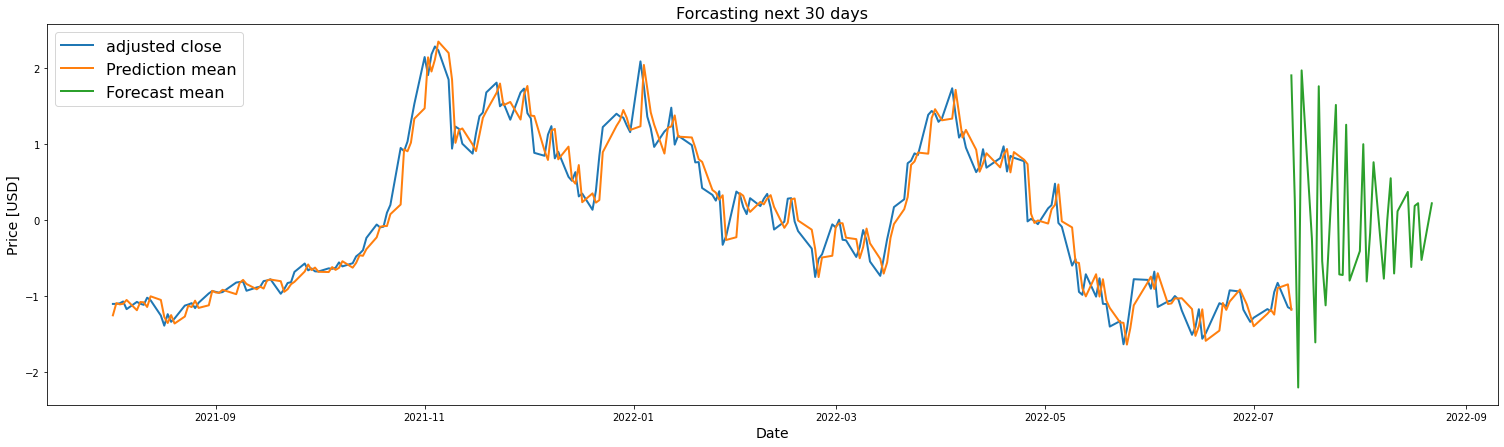

In [79]:
#plot the predictions for validation set
fig, ax = plt.subplots(1, figsize=(26, 7))
ax.plot(test_data_scaled, label='adjusted close', linewidth=2)
ax.plot(df_y_yPred_scaled, label= 'Prediction mean', linewidth=2)
ax.plot(df_forcast_scaled, label='Forecast mean', linewidth=2)
ax.set_ylabel('Price [USD]', fontsize=14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("Forcasting next 30 days", fontsize=16)
ax.legend(loc='best', fontsize=16)
